# Описание проекта

**Описание:**  Оператор связи хочет бороться с оттоком клиентов. Для этого будут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.

**Задача:** Построить модель, которая сможет предсказать разорвет ли абонент договор. Целевое показание метрики - ROC-AUC не менее 0.85.

**Ход исследования:**

- Загрузка и обзор исходных данных
- Предобработка данных
- Исследовательский анализ данных
- Подготовка данных
- Создание, обучение и анализ моделей МО
- Отчет

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install -q \
    matplotlib==3.5.3 \
    phik \
    shap
%pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import copy
import sklearn
import shap

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV,
                                     cross_val_score)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   )
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_auc_score,
                             accuracy_score,
                             confusion_matrix,
                             recall_score,
                             precision_score)
from sklearn.utils import shuffle

from sklearn.dummy import DummyClassifier

In [4]:
RANDOM_STATE = 61125
#дата актуальности информации 2020-02-01

## Работа с исходными данными

### Загрузка

In [5]:
contract = pd.read_csv('../data/contract_new.csv')
display(contract.head(5))

personal = pd.read_csv('../data/personal_new.csv')
display(personal.head(5))

internet = pd.read_csv('../data/internet_new.csv')
display(internet.head(5))

phone = pd.read_csv('../data/phone_new.csv')
display(phone.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Обзор

In [6]:
def df_info(df_name):
    display(df_name.info())
    print('Размер дф:', df_name.shape, '\n')
    print('Количество дубликатов:', df_name.duplicated().sum(), '\n')
    print('Количество пропусков:', '\n', df_name.isna().sum(), '\n')    
    print('Поиск неявных дубликатов:\n')
    for i in df_name.select_dtypes(exclude='number').columns:
        print('Уникальные значения столбца -', i, ':', df_name[i].unique())
    print()
    print('Количество идентичных пользователей:', df_name.drop('customerID', axis=1).duplicated().sum())

In [7]:
df_info(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Размер дф: (7043, 8) 

Количество дубликатов: 0 

Количество пропусков: 
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 

Поиск неявных дубликатов:

Уникальные значения столбца - customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения столбца - BeginDate : ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-

In [8]:
df_info(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Размер дф: (7043, 5) 

Количество дубликатов: 0 

Количество пропусков: 
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64 

Поиск неявных дубликатов:

Уникальные значения столбца - customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения столбца - gender : ['Female' 'Male']
Уникальные значения столбца - Partner : ['Yes' 'No']
Уникальные значения столбца - Dependents : ['No' 'Yes']

Количество идентичных пользователей: 7027


In [9]:
df_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Размер дф: (5517, 8) 

Количество дубликатов: 0 

Количество пропусков: 
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64 

Поиск неявных дубликатов:

Уникальные значения столбца - customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения столбца - InternetService : ['DSL' 'Fiber optic']
Уникальные значения столбца - OnlineSecurity : ['No' 'Yes']
Уникальные значения столбца - OnlineBackup : ['Yes' 'No']
Уникальные значения столбца - DeviceProtection : ['No' 'Yes']
Уникальные значения столбца - TechSupport : ['No' 'Yes']
Уникальные значения столбца - StreamingTV : ['No' 'Yes']
Уникальные значения столбца - StreamingMovies : ['No' 'Yes']

Количество идентичных пользователей: 5389


In [10]:
df_info(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Размер дф: (6361, 2) 

Количество дубликатов: 0 

Количество пропусков: 
 customerID       0
MultipleLines    0
dtype: int64 

Поиск неявных дубликатов:

Уникальные значения столбца - customerID : ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения столбца - MultipleLines : ['No' 'Yes']

Количество идентичных пользователей: 6359


Проблем с качеством данных нет - пропуска и дубликаты отсутсвуют.

У имеющихся исходных наборов данных разные размеры, разница в значениях достаточна велика (7000 у наибольших и 5500 в наименьшем), что не позволяет исключить клиентов для которых будут неполные данные и требуется заполнить их для использования в МО.

In [11]:
print(
    'Совпадают ли все значения id в таблицах с договарами и персональными данными:',
    (contract['customerID'] == personal['customerID']).unique()
)
print(
    'Сколько id в информации о договорах совпадают:',
    contract['customerID'].duplicated().sum(),
    ',',
    contract['customerID'].str.lower().duplicated().sum()
)
print(
    'Входят ли все id из таблицы информации об интеренет-услугах в таблицу с информацией по договорам:',
     internet['customerID'].isin(contract['customerID']).unique()
)
print(
    'Входят ли все id из таблицы информации об услугах телефонии в таблицу с информацией по договорам:',
     phone['customerID'].isin(contract['customerID']).unique()
)

Совпадают ли все значения id в таблицах с договарами и персональными данными: [ True]
Сколько id в информации о договорах совпадают: 0 , 0
Входят ли все id из таблицы информации об интеренет-услугах в таблицу с информацией по договорам: [ True]
Входят ли все id из таблицы информации об услугах телефонии в таблицу с информацией по договорам: [ True]


Среди ID клиентов совпадений нет и для всех клиентов есть информация о персональных данных и договоре.

Для всех дф с меньшим числом строк (id клиентов), все id входят в id в больших таблицах.

### Объединение данных

Присоединять таблицы имеет смысл к contract или personal, так как там наибольшие наборы данных.

Присоединять будем по customerID - ключ для всех таблиц.

In [12]:
df = (
    contract
    .merge(personal, on='customerID', how='left')
    .merge(internet, on='customerID', how='left')
    .merge(phone, on='customerID', how='left')
)
print(df.shape)

(7043, 20)


Размер данных совпадает

### Предобработка

In [13]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

Размер дф: (7043, 20) 

Количество дубликатов: 0 

Количество пропусков: 
 customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64 

Поиск неявных дубликатов:

Уникальные значения столбца - customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения столбца - BeginDate : ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '

In [14]:
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [15]:
#Приведем наименования столбцов к удобному виду
df.columns = df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()
print(df.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')


In [16]:
#Приведем даты к порядку
print('Количество абонентов имеющих активный договор:', df[df['end_date'] == 'No']['end_date'].value_counts())

df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d', errors='coerce')

print('Количество пропусков после приведения к типу даты:', df['end_date'].isna().sum())

Количество абонентов имеющих активный договор: end_date
No    5942
Name: count, dtype: int64
Количество пропусков после приведения к типу даты: 5942


Число пропусков совпадает с количеством значений No, то есть с клиентами чьи договора еще не истекли. Заменим их на дату последней актуальности - 1 февраля 2020 года, 2020-02-01.

In [17]:
#Заполняем пропуска
df['status'] = np.where(df['end_date'].isna(), 0, 1)

df['end_date'] = df['end_date'].fillna('2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

#Приведем расходы к числам
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

#Приведем данные к snake_case
col_name = df.select_dtypes(include='object').columns.to_list()
col_name.remove('customer_id')

for i in col_name:
    df[i] = df[i].str.lower().str.replace(r'[ -]', '_', regex=True)

df.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,status
0,7590-VHVEG,2020-01-01,2020-02-01,month_to_month,yes,electronic_check,29.85,31.04,female,0,...,no,dsl,no,yes,no,no,no,no,NaN,0
1,5575-GNVDE,2017-04-01,2020-02-01,one_year,no,mailed_check,56.95,2071.84,male,0,...,no,dsl,yes,no,yes,no,no,no,no,0
2,3668-QPYBK,2019-10-01,2020-02-01,month_to_month,yes,mailed_check,53.85,226.17,male,0,...,no,dsl,yes,yes,no,no,no,no,no,0
3,7795-CFOCW,2016-05-01,2020-02-01,one_year,no,bank_transfer_(automatic),42.30,1960.60,male,0,...,no,dsl,yes,no,yes,yes,no,no,NaN,0
4,9237-HQITU,2019-09-01,2020-02-01,month_to_month,yes,electronic_check,70.70,353.50,female,0,...,no,fiber_optic,no,no,no,no,no,no,no,0


In [18]:
def df_info2(df_name):
    display(df_name.info())
    print('Размер дф:', df_name.shape, '\n')
    print('Количество дубликатов:', df_name.duplicated().sum(), '\n')
    print('Количество пропусков:', '\n', df_name.isna().sum(), '\n')    
    print('Поиск неявных дубликатов:\n')
    for i in df_name.select_dtypes(include='object').columns:
        print('Уникальные значения столбца -', i, ':', df_name[i].unique())
    print()
    print('Количество идентичных пользователей:', df_name.drop('customer_id', axis=1).duplicated().sum())
    
df_info2(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

None

Размер дф: (7043, 21) 

Количество дубликатов: 0 

Количество пропусков: 
 customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
status                  0
dtype: int64 

Поиск неявных дубликатов:

Уникальные значения столбца - customer_id : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения столбца - type : ['month_to_month' 'one_year' 'two_year']
Уникальные значения столбца - paperless_billing : ['yes' 'no']
Уникальные значения столбца - payment_method : ['electronic_check' 

Данные соеденины, приведены к нужным типам и виду.

## Исследовательский анализ

In [19]:
#Проверим логичность данных
print(
    'Количество данных где договор начался позднее актуальной даты:',
    df[df['begin_date'] > '2020-02-01'].value_counts().sum()
)
print(
    'Количество данных где договор закончился позднее актуальной даты:',
    df[df['end_date'] > '2020-02-01'].value_counts().sum()
)
print(
    'Количество данных, где договор начался раньше чем закончился:',
    df[df['begin_date'] > df['end_date']].value_counts().sum()
)

Количество данных где договор начался позднее актуальной даты: 0
Количество данных где договор закончился позднее актуальной даты: 0
Количество данных, где договор начался раньше чем закончился: 0


In [20]:
#Добавим признак продолжительность действия договора в днях
df['duration'] = df['end_date'] - df['begin_date']
df['duration'] = (df['duration']/pd.Timedelta(days=1)).astype(int)

In [21]:
num_cols = ['monthly_charges', 'total_charges', 'duration']
date_col = ['begin_date', 'end_date']
cat_col = [col for col in df.columns if col not in num_cols + ['customer_id'] + date_col]

Признак monthly_charges
Среднее: 64.76
Медиана: 70.35
Минимальное значение: 18.25 Максимальное значение: 118.75


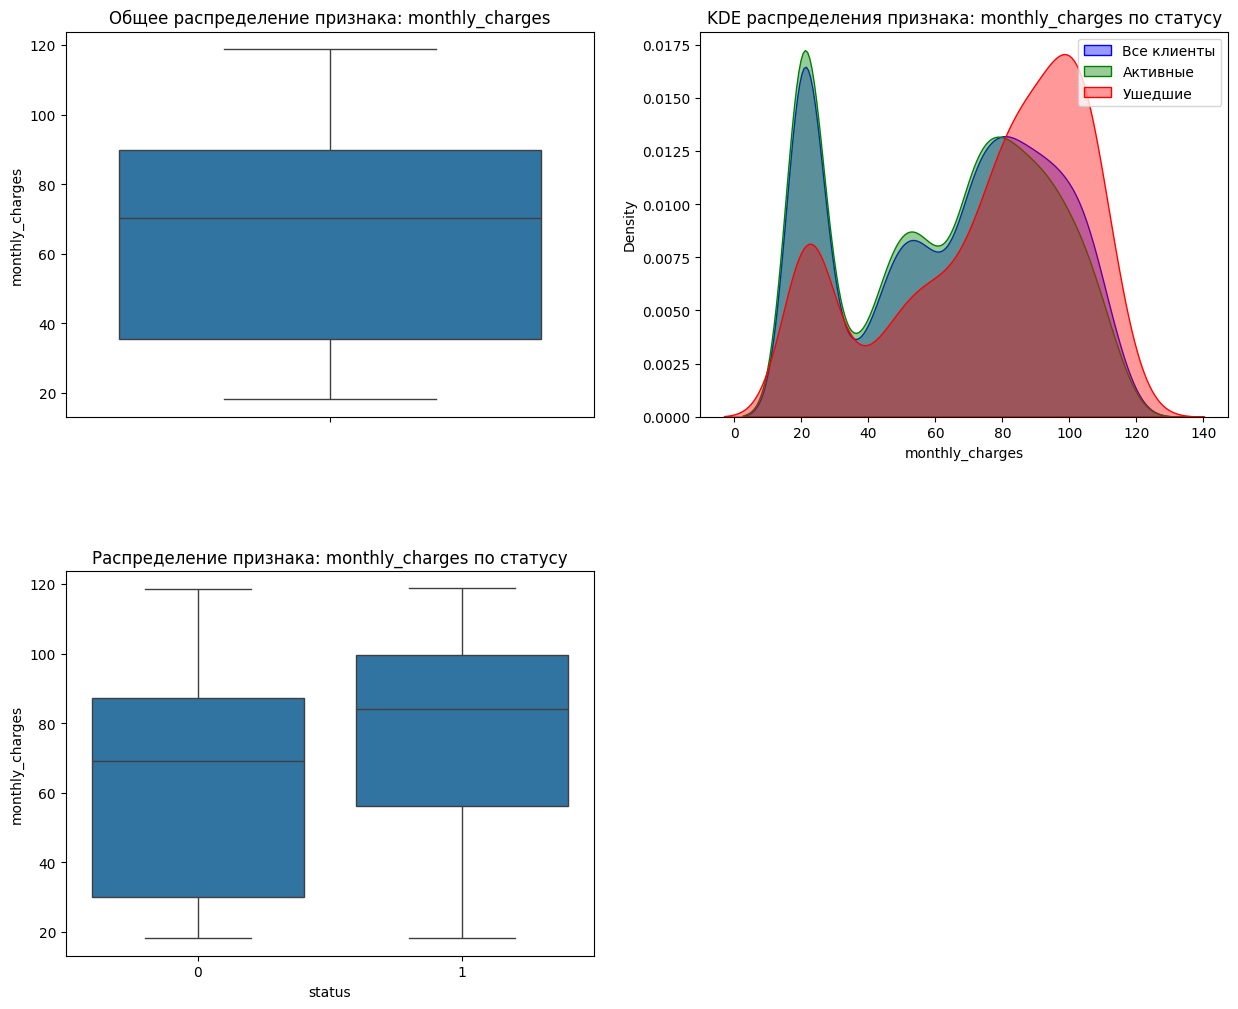

Признак total_charges
Среднее: 2118.62
Медиана: 1345.28
Минимальное значение: 19.05 Максимальное значение: 9221.38


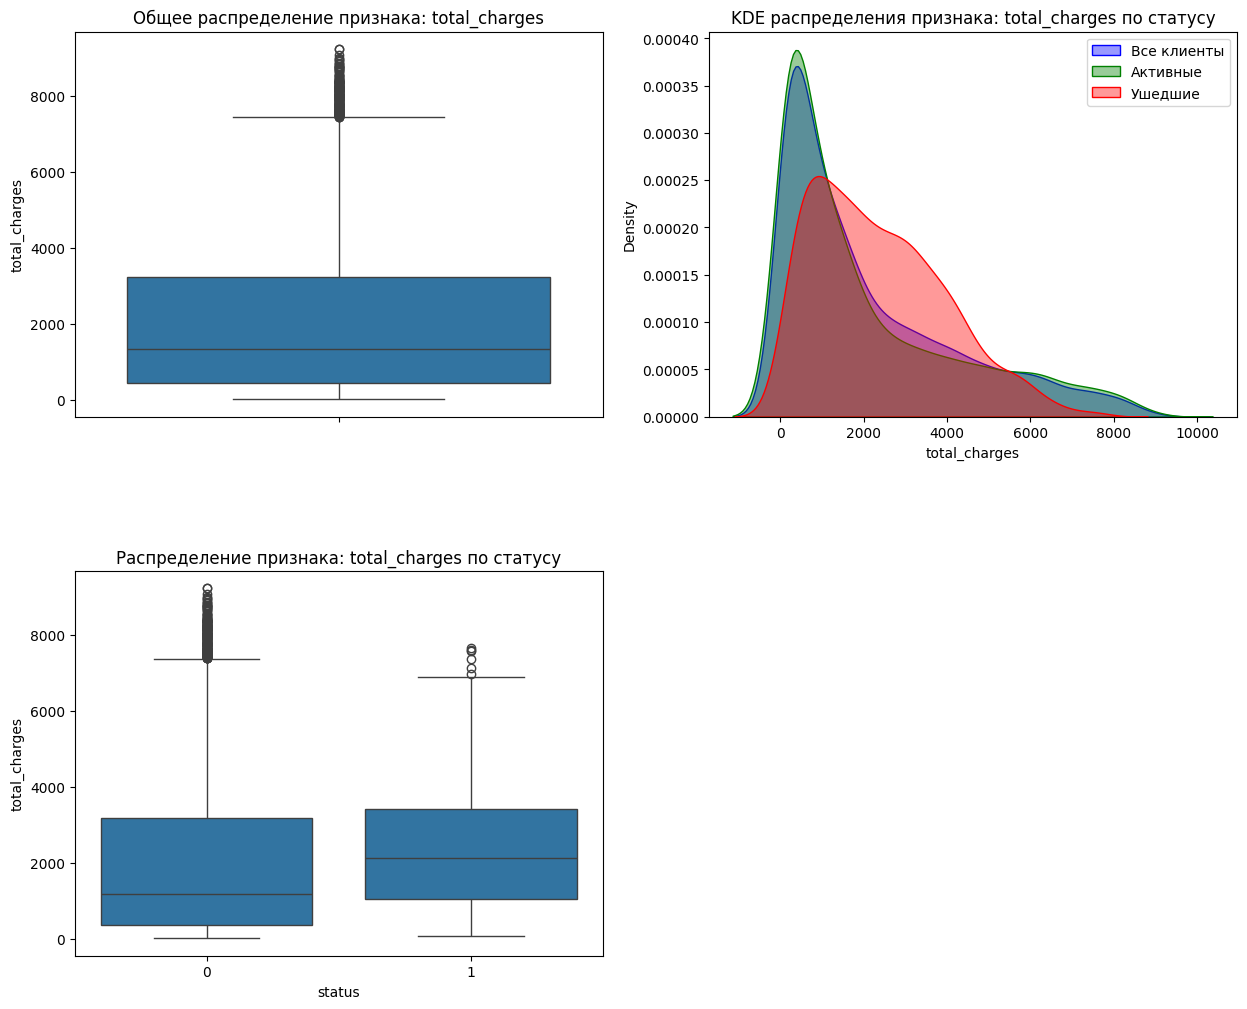

Признак duration
Среднее: 898.56
Медиана: 761.0
Минимальное значение: 0 Максимальное значение: 2314


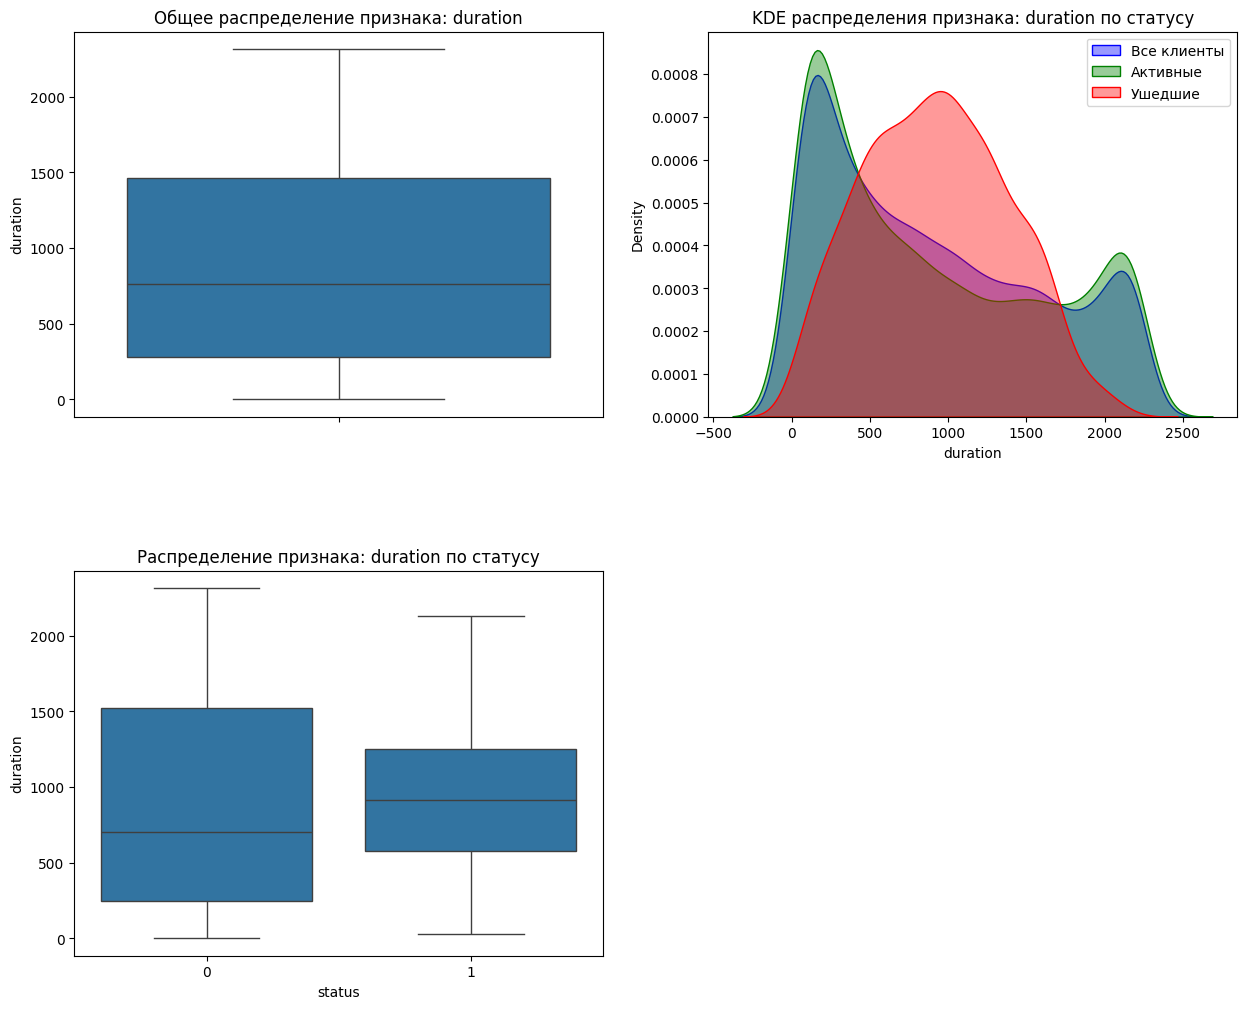

In [22]:
for i in num_cols:
    print('Признак', i)
    print('Среднее:', round(df[i].mean(), 2))
    print('Медиана:', round(df[i].median(), 2))
    print('Минимальное значение:', min(df[i]), 'Максимальное значение:', max(df[i]))
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    sns.boxplot(data=df, y=i, ax=axes[0,0])
    axes[0,0].set_title(f'Общее распределение признака: {i}')

    sns.kdeplot(
        df[i],
        fill=True,
        alpha=0.4,
        color='blue',
        common_norm=False,
        ax=axes[0,1],
        label='Все клиенты'
    )

    sns.kdeplot(
        df[df['status']==0][i],
        fill=True,
        alpha=0.4,
        color='green',
        common_norm=False,
        ax=axes[0,1],
        label='Активные'
    )

    sns.kdeplot(
        df[df['status']==1][i],
        fill=True,
        alpha=0.4,
        color='red',
        common_norm=False,
        ax=axes[0,1],
        label='Ушедшие'
    )

    axes[0,1].set_title(f'KDE распределения признака: {i} по статусу')
    axes[0,1].legend()

    sns.boxplot(data=df, y=i, ax=axes[1, 0], x='status')
    axes[1, 0].set_title(f'Распределение признака: {i} по статусу')

    axes[1,1].axis('off')
    
    plt.show()


Общее для всех количественных признаков - общее распределение формируется клиентами не разорвавшими договор (статус 0).

Признак расходы за месяц - первую группу пользователей можно выделить около значения 20 с узким высоким пиком, а вторую более широкую на значениях 40 - 110 с пиком на 80. Ушедшие пользователи также имели группы около значения 20, но в отличии от активных, максимальный пик приходится на значение 100 и основная группа в диапазоне 80 -110.

Признак суммарные расходы - для активных пользователей пик около значения 500 и резкое убывание к 2000, после чего плавное убывание к 9000 до нулевой плотности. Ушедшие клиенты отличаются тем, что их пик смещен примерно 1000 и имеет более широкое распределение - убывание более плавное и становится ниже чем у активных пользователей только около 6000.

Признак продолжительность - для всех клиентов вместе и активных, одинаковая картина: смешанное распределение имеет максимум продолжительности около занчений 100-150, последующим убыванием к 1750 и затем затем еще один пик около значения 2100. Распределение для ушедших пользоователей значительно отличается - распределение похоже на нормальнок с пиком на 1000 и равномерным убыванием к 0 и 2000.

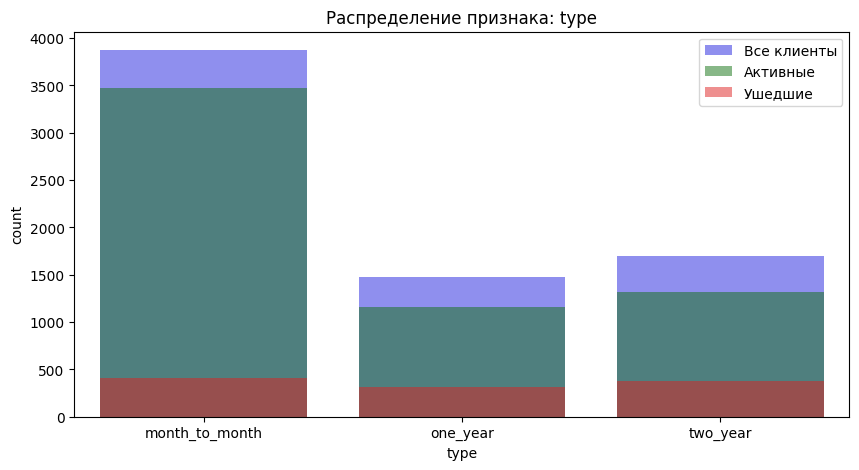

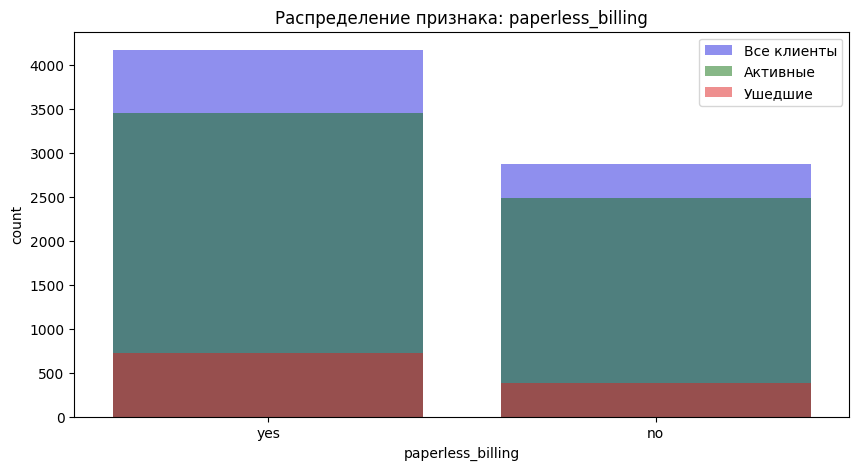

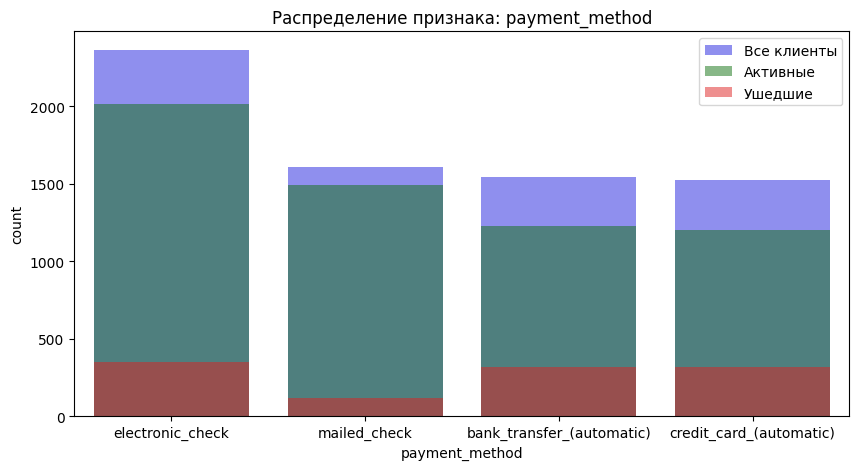

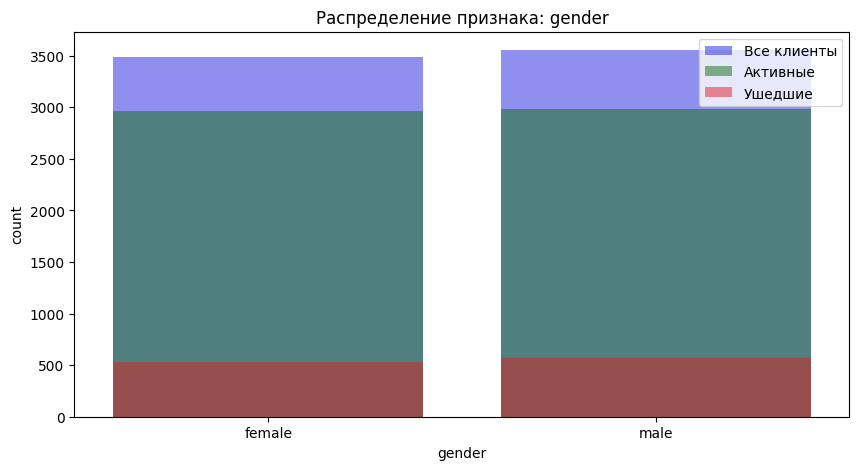

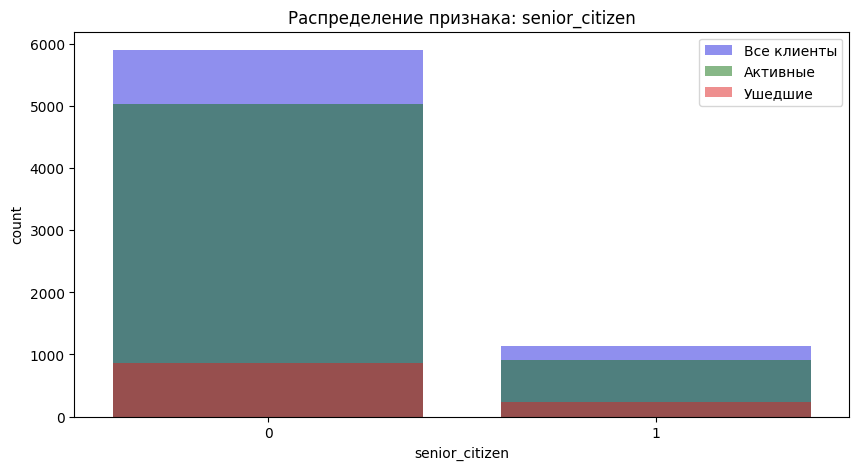

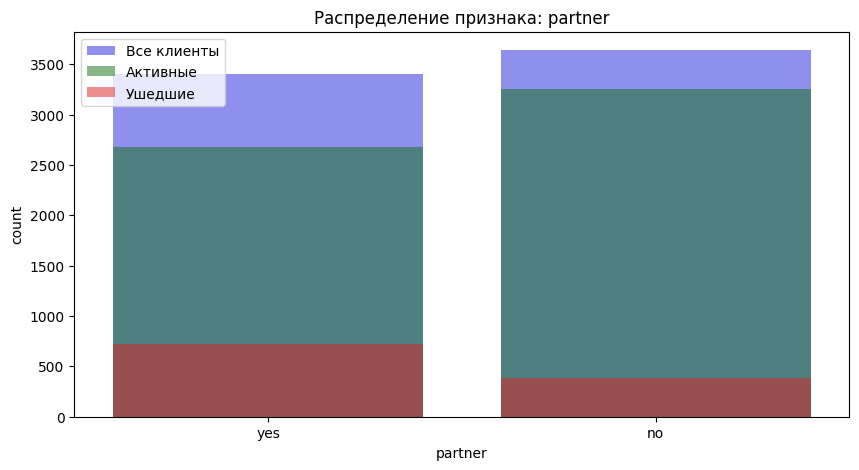

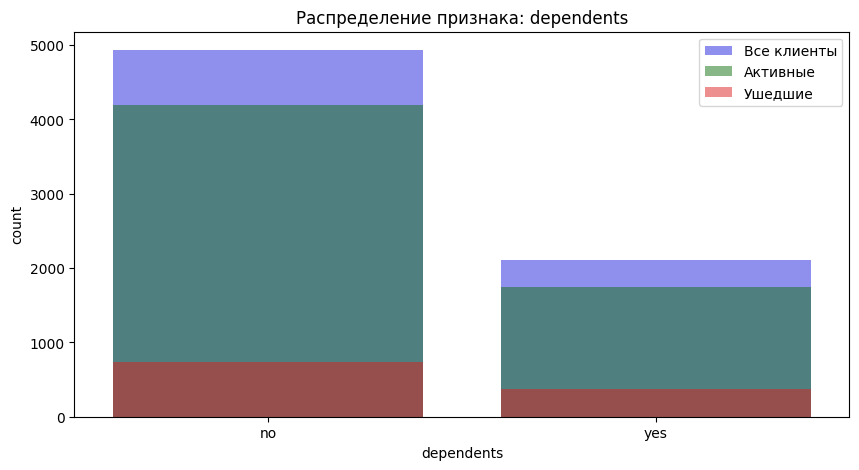

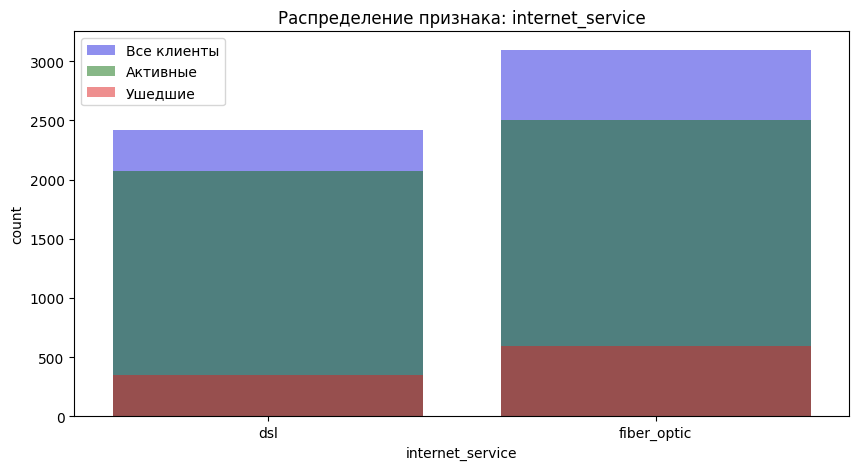

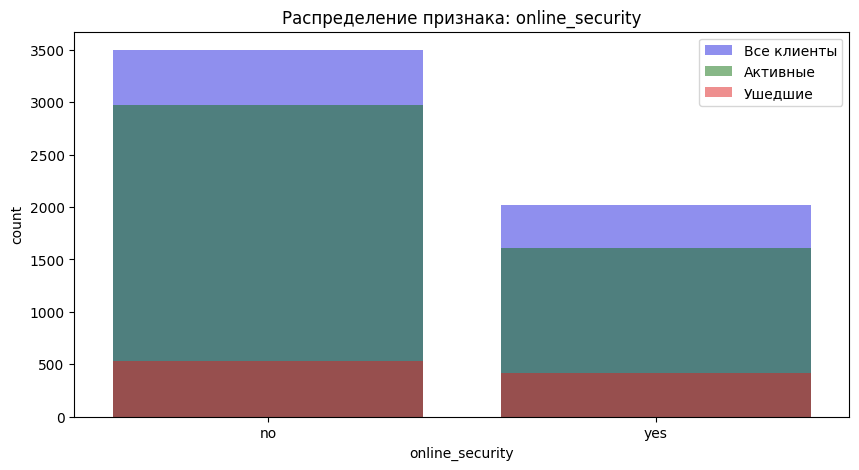

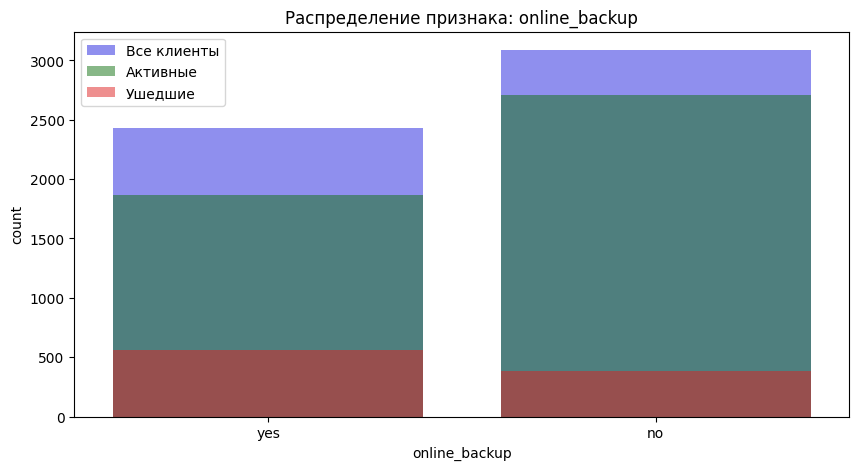

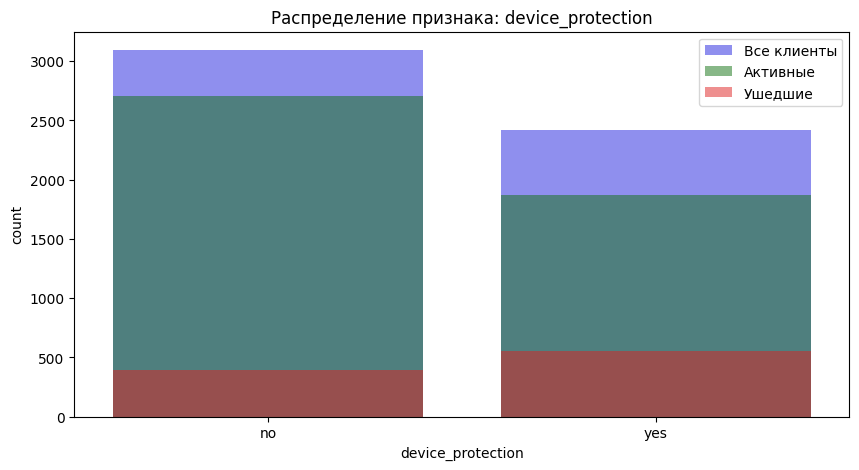

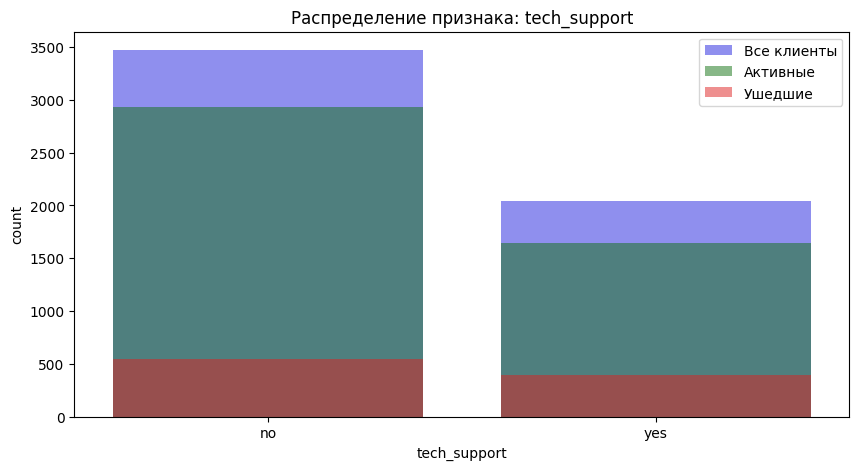

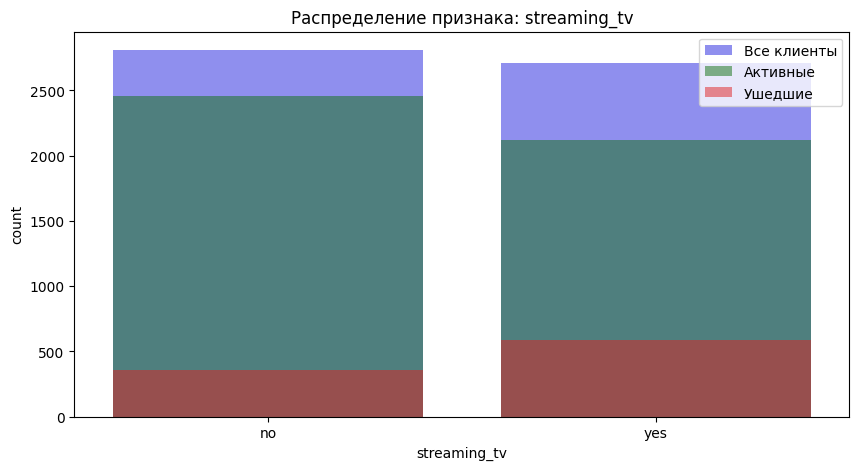

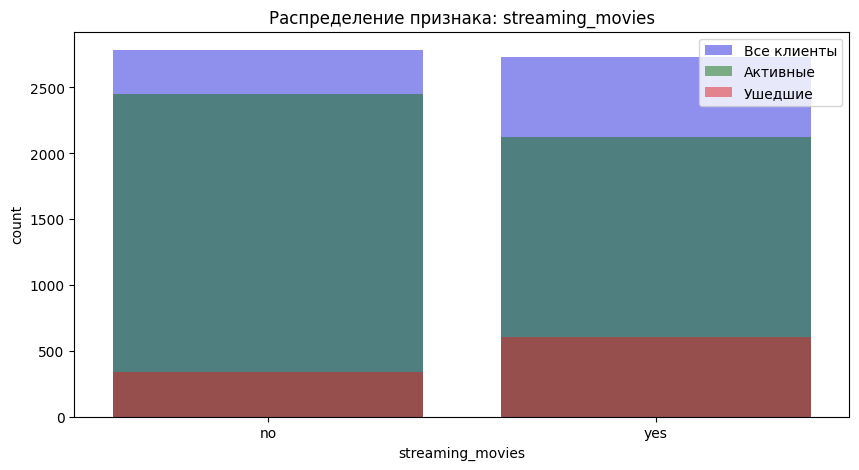

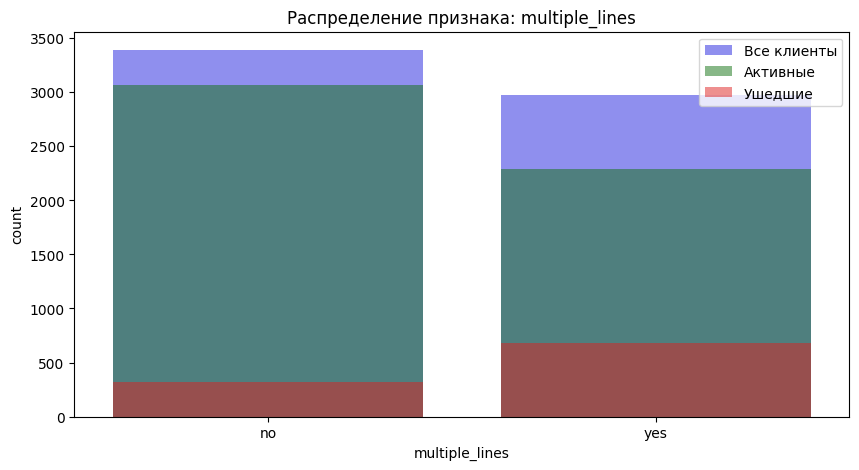

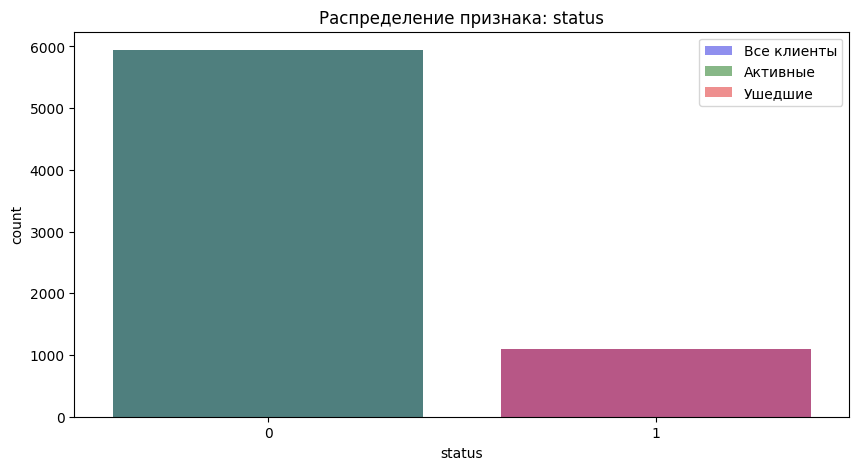

In [23]:
for i in cat_col:
    plt.figure(figsize=(10,5))

    sns.countplot(data=df, x=i, color='blue', alpha=0.5, label='Все клиенты')

    sns.countplot(data=df[df['status'] == 0], x=i, color='green', alpha=0.5, label='Активные')
    sns.countplot(data=df[df['status'] == 1], x=i, color='red', alpha=0.5, label='Ушедшие')
    
    plt.title(f'Распределение признака: {i}')
    plt.legend()
    plt.show()

Для большинства категориальных признаков характерно сохранение поведения клиентов со статусами о и 1 таким же, как и на общем распределении.

Отдельно стоит отметить признаки, где распределения какой-то из групп клиентов отличается от общего, так как подобные признаки могут охарактеризовать и отделить групы друг от друга:
- в равной степени предпочитают разные типы оплаты
- доля имевших электронный расчетный лист, среди ушедших клиентов выше, чем у тех у кого его не было
- ушедшие клиенты практически не пользовались оплатой по почте
- среди ушедших, почти двукратное большинство среди тех кто имеет партнера, при том что у оставшихся клиентов разницы нет
- среди ушедших клиентов, значительно выше доля клиентов без детей
- практически равное соотношение среди ушедших клиентов, кто пользовался блокировкой сайтов и нет
- немного ниже доля тех кто пользовался облачным хранилищем среди ушедших клиентов
- немного выше доля тех кто пользовался антивирусом среди ушедших клиентов
- среди ушедших клиентов было популярнее стриминговое телевидение, каталог фильмов и подключение телефона к нескольким линиям

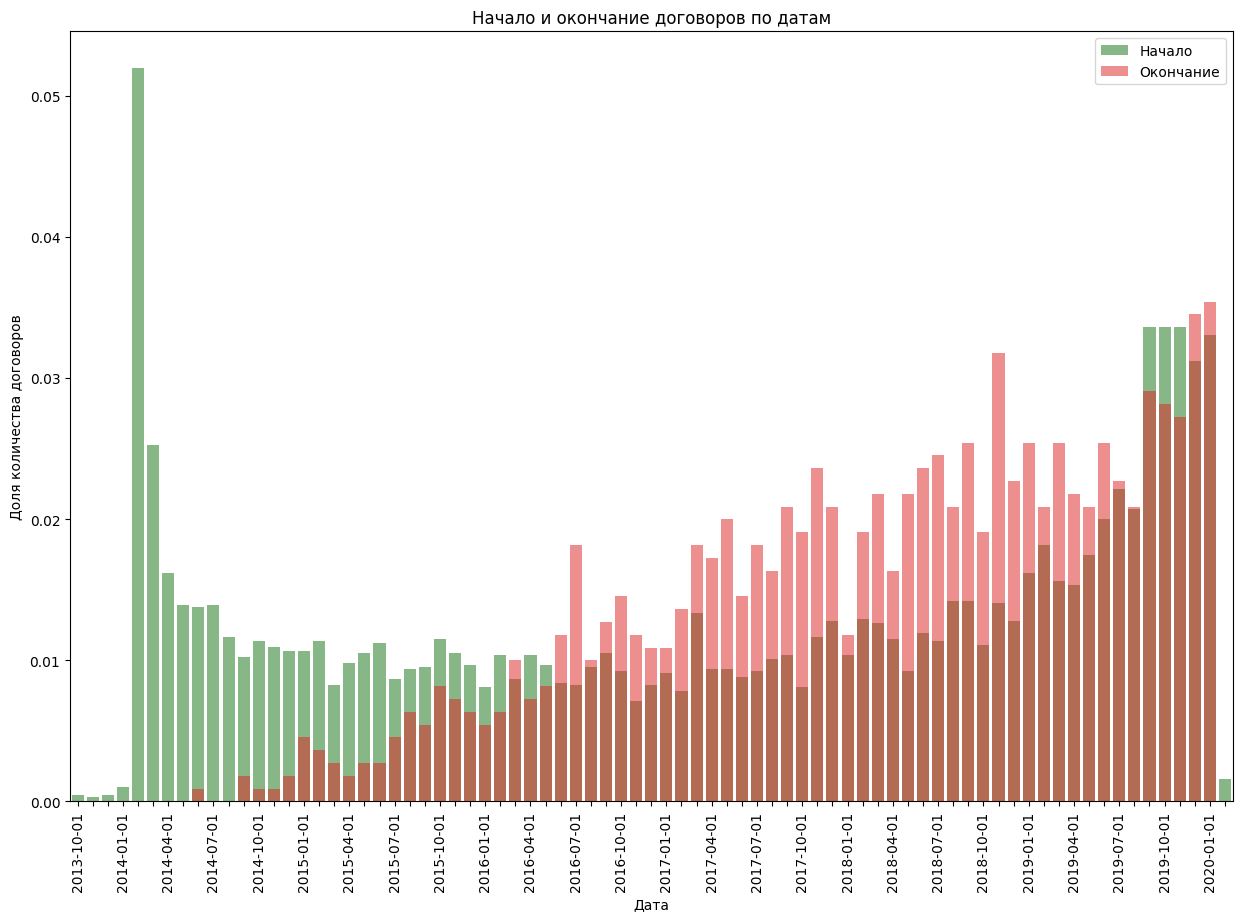

In [24]:
begin_counts = df['begin_date'].value_counts().sort_index()
end_counts = df.loc[df['end_date'] != pd.Timestamp('2020-02-01'), 'end_date'].value_counts().sort_index()


begin_counts = begin_counts / begin_counts.sum()
end_counts = end_counts / end_counts.sum()

plt.figure(figsize=(15,10))

sns.barplot(
    x=begin_counts.index.astype(str), y=begin_counts.values,
    alpha=0.5, color='green', label='Начало'
)

sns.barplot(
    x=end_counts.index.astype(str), y=end_counts.values,
    alpha=0.5, color='red', label='Окончание'
)

plt.xticks(rotation=90)

for i, label in enumerate(plt.gca().get_xticklabels()):
    if i % 3 != 0:
        label.set_visible(False)     

plt.ylabel('Доля количества договоров')
plt.xlabel('Дата')
plt.title('Начало и окончание договоров по датам')
plt.legend()
plt.show()

По графику количества открытий и завершений договоров видно, что в самом начале значительный пик - вероятно связан с открытием кампании и выходом ее в свет после чего резкий 3-х кратный спад всего за полгода. Вероятно связан с пиар кампанией на открытии и бонусами/пробными подписками, бесплатным периодом и т.п. Далее количество ежемесячных заключенных договоров стоит на месте примерно до 2018-02-01, после чего начинается плавный рост. Количество завершенных договоров плавно стабильно растет.

Клиентов разорвавших договор можно охарактеризовать следующим образом:
- медианное значение трат выше чем у действующих пользователей, а разброс значений ниже
- имели медианное значение длительности договора немного выше чем у действующих клиентов
- не имеют детей и менее заинтересованы в блокировке опасных сайтов
- предпочитают электронные способы получения платежных поручений и оплаты
- более заинтересованы в антивирусе
- менее заинтересованы в облачном хранилище
- заинтересованы в стриминговых услугах, а также подключении телефона к нескольким линиям

Для полной картины не хватает данных о возрасте клиентов, однако можно предположить, что большинство ушедших клиентов - это молодые люди, с партнером, но без детей, не заинтересованые в ограничениях интернет-контента, однако вследствии этого более заинтересованные в антивирусе, а также предпочитающие стриминговые сервисы.

In [25]:
num_cols = df.drop('status', axis=1).select_dtypes(include='number')
cat_cols = df.drop('customer_id', axis=1).select_dtypes(include='object')

portrait_medians = []
portrait_modes = []

for col in num_cols:
    median_0 = df[df['status'] == 0][col].median()
    median_1 = df[df['status'] == 1][col].median()
    portrait_medians.append([col, median_0, median_1])

for col in cat_cols:
    mode_0 = df[df['status'] == 0][col].mode()[0]
    mode_1 = df[df['status'] == 1][col].mode()[0]
    portrait_modes.append([col, mode_0, mode_1])

portrait_num = pd.DataFrame(portrait_medians, columns=['Признак', 'Активные', 'Ушедшие'])
portrait_cat = pd.DataFrame(portrait_modes, columns=['Признак', 'Активные', 'Ушедшие'])

portrait_df = pd.concat([portrait_num, portrait_cat], ignore_index=True)
print('Сравнение медиан и мод признаков, где они не равны')
display(portrait_df[portrait_df['Активные'] != portrait_df['Ушедшие']].reset_index(drop=True))

Сравнение медиан и мод признаков, где они не равны


,Признак,Активные,Ушедшие
0,monthly_charges,69.2,84.2
1,total_charges,1194.28,2139.03
2,duration,702.0,915.0
3,partner,no,yes
4,online_backup,no,yes
5,device_protection,no,yes
6,streaming_tv,no,yes
7,streaming_movies,no,yes
8,multiple_lines,no,yes


## Работа с признаками

Признак customer_id неиформативен - отбросим

Признак end_date преобразован в целевой признак status, отбросим

Признак begin_date по сути является комбинацией целевого признака с признаком duration, смысла в нем нет - отбросим

Признак gender - равное распределние между мужчинами и женщинами, как в общем по всем, так и по статусу - то есть признак ничего не описывает, можно отбросить

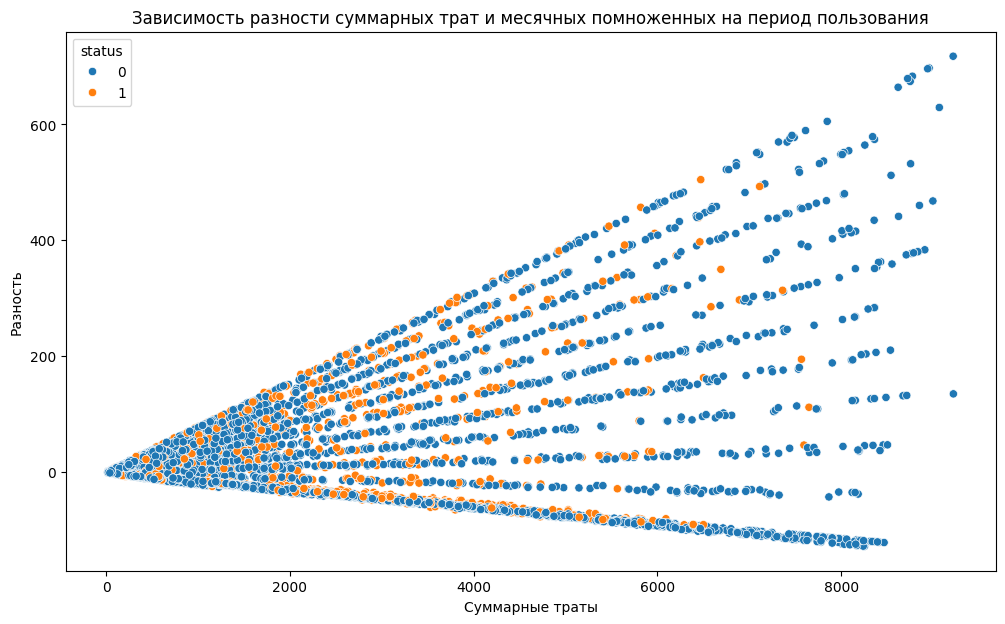

In [26]:
df['test'] = df['total_charges'] - df['monthly_charges'] * df['duration']/30

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y='test', x='total_charges', hue='status')
plt.title('Зависимость разности суммарных трат и месячных помноженных на период пользования')
plt.xlabel('Суммарные траты')
plt.ylabel('Разность')
plt.show()

Признак total_charges, не является простой комбинацией признаков monthly_charges и duration, поэтому оставим его.

In [27]:
df = df.drop(['customer_id', 'begin_date', 'end_date', 'gender', 'test'], axis=1)

## Корреляционный анализ

In [28]:
corr_matrix = df.phik_matrix(
    interval_cols=['monthly_charges', 'total_charges', 'duration']
)
display(corr_matrix)

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,status,duration
type,1.000000,0.106860,0.277462,0.388266,0.470700,0.086231,0.179736,0.147680,0.115464,0.253529,0.195386,0.247180,0.293239,0.163095,0.167051,0.071275,0.094015,0.634155
paperless_billing,0.106860,1.000000,0.370495,0.467783,0.202168,0.242133,0.013218,0.172593,0.363514,0.215271,0.000000,0.029758,0.135913,0.182356,0.155905,0.269304,0.083398,0.026799
payment_method,0.277462,0.370495,1.000000,0.399536,0.334563,0.292725,0.243008,0.224903,0.434448,0.365104,0.269205,0.297768,0.372982,0.247449,0.255010,0.369809,0.214832,0.350964
monthly_charges,0.388266,0.467783,0.399536,1.000000,0.711148,0.304691,0.203237,0.184213,0.948738,0.364891,0.428024,0.495800,0.402669,0.733083,0.727985,0.475869,0.225925,0.387579
total_charges,0.470700,0.202168,0.334563,0.711148,1.000000,0.136856,0.383135,0.085809,0.300293,0.412771,0.516033,0.540465,0.446167,0.529015,0.526443,0.581188,0.303758,0.847321
senior_citizen,0.086231,0.242133,0.292725,0.304691,0.136856,1.000000,0.016992,0.324576,0.309469,0.170667,0.000000,0.000000,0.209633,0.047996,0.075309,0.237594,0.086159,0.063315
partner,0.179736,0.013218,0.243008,0.203237,0.383135,0.016992,1.000000,0.652122,0.000000,0.265177,0.267471,0.290089,0.223082,0.239923,0.226459,0.232543,0.226688,0.453688
dependents,0.147680,0.172593,0.224903,0.184213,0.085809,0.324576,0.652122,1.000000,0.206200,0.244955,0.150651,0.131018,0.212178,0.080593,0.030894,0.035777,0.046871,0.198729
internet_service,0.115464,0.363514,0.434448,0.948738,0.300293,0.309469,0.000000,0.206200,1.000000,0.341950,0.008098,0.000000,0.326553,0.260564,0.246018,0.337835,0.098956,0.059168
online_security,0.253529,0.215271,0.365104,0.364891,0.412771,0.170667,0.265177,0.244955,0.341950,1.000000,0.277245,0.263021,0.415484,0.065004,0.084426,0.080520,0.107962,0.458772


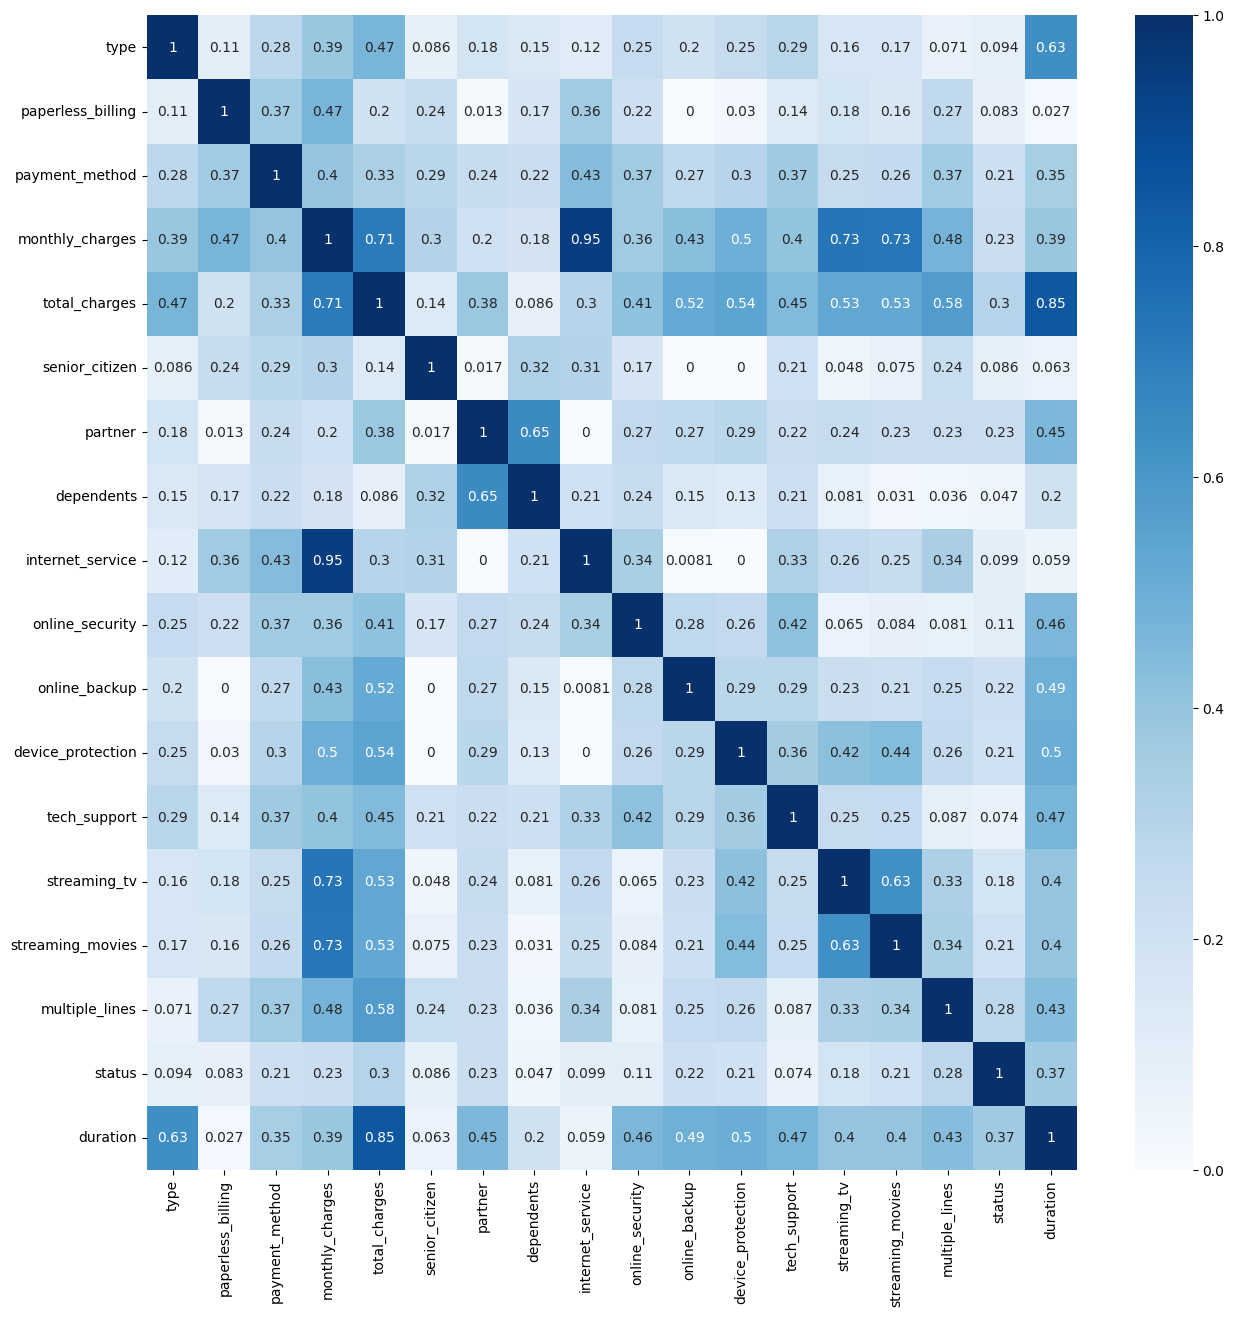

In [29]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='Blues');

Анализ корреляции признаков

Значительное число признаков имеют слабую (0.3-0.5) или отсутсвующую корреляцию (<0.3).

Признаки ежемесячных трат и суммарных трат имеют достаточное количество средних (0.5-0.7) и сильных (0.7-0.9) коэффициентов корреляции с  признаками отражающими подключенные услуги, что ожидаемо ведь траты складываются из этих услуг.

Мультиколлинеарность наблюдается только в одном случае - между признаками ежемесячных трат и типом интернет-подключения, что вполне объясняемо.

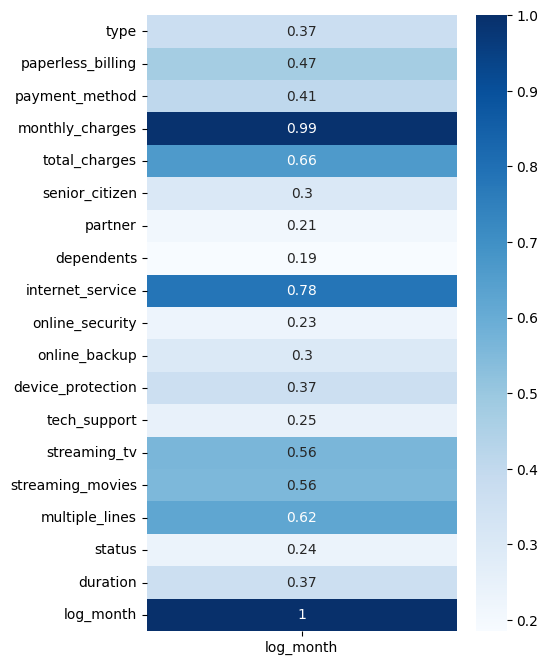

In [30]:
df['log_month'] = np.log(df['monthly_charges'] + 1)

corr_matrix = df.phik_matrix(
    interval_cols=['monthly_charges', 'total_charges', 'duration', 'log_month']
)

heatmap_data = corr_matrix[['log_month']]

plt.figure(figsize=(5, 8))
sns.heatmap(heatmap_data, annot=True, cmap='Blues');

Заменим месячные траты на их логарифм - это уберет мультиколлинеарность

In [31]:
df = df.drop('monthly_charges', axis=1)

## Подготовка данных

In [32]:
for i in df.select_dtypes(include='object').columns:
    print(i + ',', len(df[i].unique()), 'уникальных значений' +':', df[i].unique())

type, 3 уникальных значений: ['month_to_month' 'one_year' 'two_year']
paperless_billing, 2 уникальных значений: ['yes' 'no']
payment_method, 4 уникальных значений: ['electronic_check' 'mailed_check' 'bank_transfer_(automatic)'
 'credit_card_(automatic)']
partner, 2 уникальных значений: ['yes' 'no']
dependents, 2 уникальных значений: ['no' 'yes']
internet_service, 3 уникальных значений: ['dsl' 'fiber_optic' nan]
online_security, 3 уникальных значений: ['no' 'yes' nan]
online_backup, 3 уникальных значений: ['yes' 'no' nan]
device_protection, 3 уникальных значений: ['no' 'yes' nan]
tech_support, 3 уникальных значений: ['no' 'yes' nan]
streaming_tv, 3 уникальных значений: ['no' 'yes' nan]
streaming_movies, 3 уникальных значений: ['no' 'yes' nan]
multiple_lines, 3 уникальных значений: [nan 'no' 'yes']


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('status', axis=1),
    df['status'],
    test_size=0.25,
    stratify=df['status'],
    random_state=RANDOM_STATE
)

In [34]:
#Для логистической регрессии
ohe_col = X_train.select_dtypes(include='object').columns.tolist()
num_col = X_train.select_dtypes(exclude='object').columns.tolist()
num_col = [col for col in num_col if col != 'senior_citizen']

ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_col),
    ('num', num_pipe, num_col)
])

In [35]:
#Для деревянных моделей
ord_col2 = X_train.select_dtypes(include='object').columns.tolist()

ord_pipe2 = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

num_pipe2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

data_preprocessor2 = ColumnTransformer([
    ('num', num_pipe2, num_col),
    ('ord', ord_pipe2, ord_col2)
])

In [36]:
#Диссбаланс классов
display(y_train.value_counts())
print(
    'Число объектов целевого класса от общего:',
    round(y_train.value_counts()[1]/y_train.value_counts()[0], 2)
)

status
0    4456
1     826
Name: count, dtype: int64

Число объектов целевого класса от общего: 0.19


## Обучение моделей

### Линейная регрессия

In [37]:
logreg_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

logreg_param = {
    'model__class_weight': [{0: 1, 1: w} for w in [1, 2, 3, 5, 10]],
    'model__C': [0.01, 0.1, 1, 3, 5, 10]
}

grid = GridSearchCV(
    logreg_pipe,
    param_grid=logreg_param,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [38]:
logreg_study = grid.fit(X_train, y_train)

display('Лучшая модель:', logreg_study.best_params_)
print(
    'Метрика лучшей модели, ROC-AUC: ',
    round(logreg_study.best_score_, 2)
)

'Лучшая модель:'

{'model__C': 10, 'model__class_weight': {0: 1, 1: 5}}

Метрика лучшей модели, ROC-AUC:  0.77


### Дерево решений

In [39]:
tree_pipe = Pipeline([
    ('preprocessor', data_preprocessor2),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

tree_param = {
    'model__max_depth': range(5, 11),
    'model__min_samples_split': range(2, 11),
    'model__min_samples_leaf': range(1, 11),
    'model__max_features': [None, 'sqrt', 'log2']
}

rand_search_tree = RandomizedSearchCV(
    tree_pipe,
    param_distributions = tree_param,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=15,
    random_state=RANDOM_STATE
)

In [40]:
tree_study = rand_search_tree.fit(X_train, y_train)

display('Лучшая модель:', tree_study.best_params_)
print(
    'Метрика лучшей модели, ROC-AUC: ',
    round(tree_study.best_score_, 2)
)

'Лучшая модель:'

{'model__min_samples_split': 8,
 'model__min_samples_leaf': 3,
 'model__max_features': None,
 'model__max_depth': 5}

Метрика лучшей модели, ROC-AUC:  0.79


### Случайный лес

In [41]:
forest_pipe = Pipeline([
    ('preprocessor', data_preprocessor2),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))
])

forest_param = {
    'model__n_estimators': [100, 200, 300], 
    'model__max_depth': range(5, 11),
    'model__min_samples_split': range(2, 11),
    'model__min_samples_leaf': range(1, 11),
    'model__max_features': [None, 'sqrt', 'log2']
}

rand_search_forest = RandomizedSearchCV(
    forest_pipe,
    param_distributions = forest_param,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=15,
    random_state=RANDOM_STATE
)

In [ ]:
forest_study = rand_search_forest.fit(X_train, y_train)

display('Лучшая модель:', forest_study.best_params_)
print(
    'Метрика лучшей модели, ROC-AUC: ',
    round(forest_study.best_score_, 2)
)

### Бустинг

In [ ]:
cat_col = X_train.select_dtypes(include='object').columns.tolist()
for col in cat_col:
    X_train[col] = X_train[col].astype('category')

lgbm_model = LGBMClassifier(
    random_state=RANDOM_STATE
)

lgbm_param = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1],
    'num_leaves': [10, 30, 50, 80],
    'max_depth': [3, 5, 7]
}

rand_search_lgbm = RandomizedSearchCV(
    lgbm_model,
    param_distributions = lgbm_param,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=15,
    random_state=RANDOM_STATE
)

In [ ]:
lgbm_study = rand_search_lgbm.fit(X_train, y_train)

display('Лучшая модель:', lgbm_study.best_params_)
print(
    'Метрика лучшей модели, ROC-AUC: ',
    round(lgbm_study.best_score_, 2)
)

'Лучшая модель:'

{'num_leaves': 10, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1}

Метрика лучшей модели, ROC-AUC:  0.88


### Сравнение моделей

In [ ]:
result = [
    round(logreg_study.best_score_, 2),
    round(tree_study.best_score_, 2),
    round(forest_study.best_score_, 2),
    round(lgbm_study.best_score_, 2)
]

name = ['log_reg', 'tree', 'forest', 'lgbm']

results_df = pd.DataFrame({'model': name,'roc_auc': result})

results_df = results_df.sort_values('roc_auc', ascending=False).reset_index(drop=True)
display(results_df)

,model,roc_auc
0,lgbm,0.88
1,forest,0.84
2,tree,0.79
3,log_reg,0.77


Валидация разных моделей показала, что хуже всех справилась линейная регрессия, дерево немного лучше, лес практически достигает необходимого порога, а бустинг получает метрику выше целевой. Это говорит о сложной, нелинейной связи между целевым признаком и тренировочными.

## Тестирование модели

In [ ]:
for col in cat_col:
    X_test[col] = X_test[col].astype('category')

y_pred_proba = lgbm_study.best_estimator_.predict_proba(X_test)[:, 1]

y_pred_class = (y_pred_proba > 0.5).astype(int)

print('Roc-Auc:', round(roc_auc_score(y_test, y_pred_proba), 2))
print('Accuracy:', round(accuracy_score(y_test, y_pred_class), 2))

Roc-Auc: 0.9
Accuracy: 0.91


Модель получила метрику равную метрике на кросс-валидации - значит обучение прошло успешно, проблем с переобучением нет.

У модели высокий показатель roc-auc, что это означает - модель научилась с высокой вероятностью правильно различать пользователей разных классов, независимо от порога классификации.

У модели также высокие показатели точности, однако в данных высокий диссбаланс - поэтому метрика может быть обманчива, просто проставив всем предсказанным объектам 0 класс, значение точности будет около 0.85. То, что точность модели выше означает, что она не просто ставит везде одинаковый класс, а умеет именно определять класс.

### Дамми-модель

In [ ]:
dummy = DummyClassifier(strategy='most_frequent', random_state=42)

dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)
y_proba = dummy.predict_proba(X_test)[:, 1]

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 2))

Accuracy: 0.84
ROC-AUC: 0.5


У модели на тесте значительно более высокие показатели roc-auc по сравнению с константной моделью и более высокое значение точности - это показывает, что модель научилась именно определять а не угадывать классы пользователей.

## Анализ важности признаков

In [ ]:
best_model = lgbm_study.best_estimator_
X_sample = shuffle(X_test, random_state=RANDOM_STATE).iloc[:300]
explainer = shap.TreeExplainer(best_model)

X_sample_str = X_sample.copy()
for col in cat_col:
    X_sample_str[col] = X_sample_str[col].astype(str)

shap_expl = explainer(X_sample)

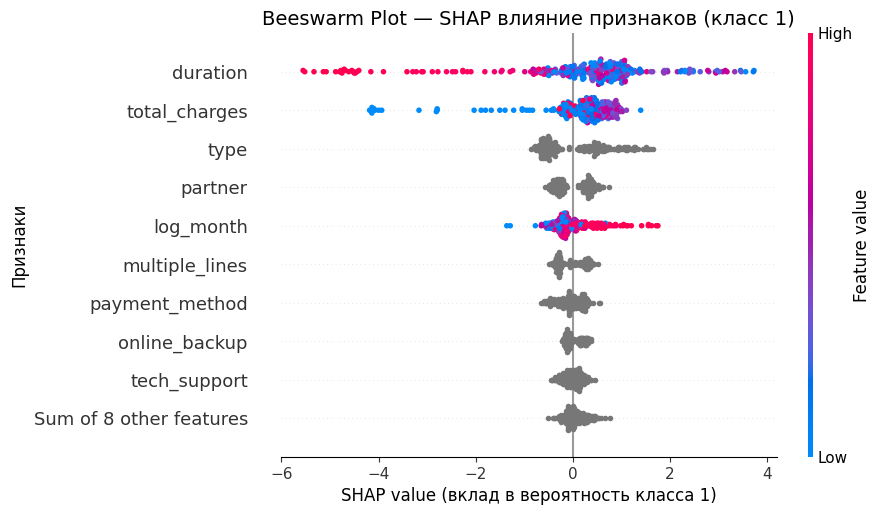

In [ ]:
shap.plots.beeswarm(
    shap.Explanation(
        values = shap_expl.values,
        data = X_sample_str.values,
        feature_names = X_sample_str.columns.tolist()
    ),
    show=False
)

plt.title("Beeswarm Plot — SHAP влияние признаков (класс 1)", fontsize=14)
plt.xlabel("SHAP value (вклад в вероятность класса 1)", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.show()

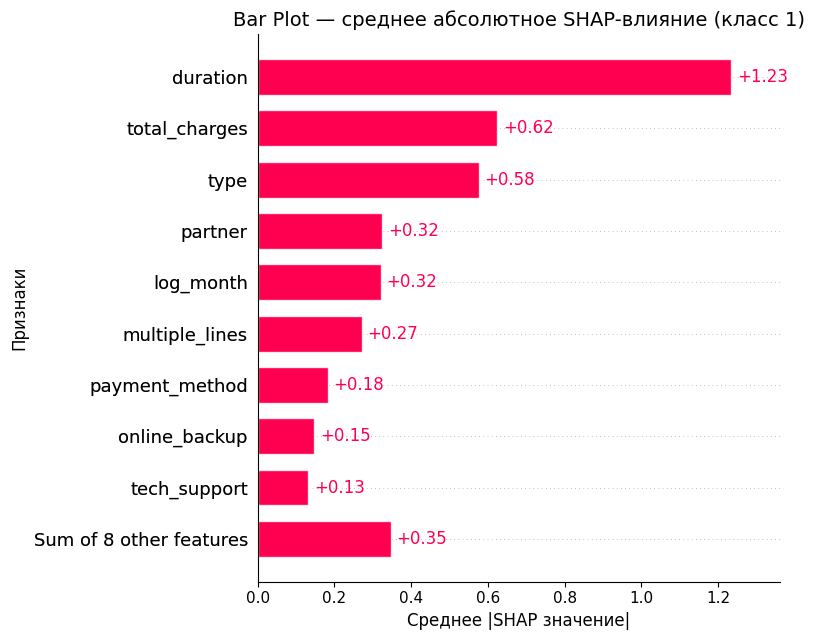

In [ ]:
shap.plots.bar(
    shap.Explanation(
        values = shap_expl.values,
        data = X_sample_str.values,
        feature_names = X_sample_str.columns.tolist()
    ),
    show=False
)
plt.title("Bar Plot — среднее абсолютное SHAP-влияние (класс 1)", fontsize=14)
plt.xlabel("Среднее |SHAP значение|", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.tight_layout()
plt.show()

Среди признаков, наибольший абсолютный вклад вносят длительность, тип оплаты, месячные и годовые траты и наличие партнера. Глобально - для большинства признаков имеющих значимый вклад были отмечены особенности в ходе исследовательского анализа.

Стоит отметить сложную структуру вклада длительности - наложение друг на друга высоких, низких и средних значений признака во вклад. Подобное и у признака суммарных трат, где вообще не представляется возможным разделить вклад высоких и низких значений.

## Ошибки модели

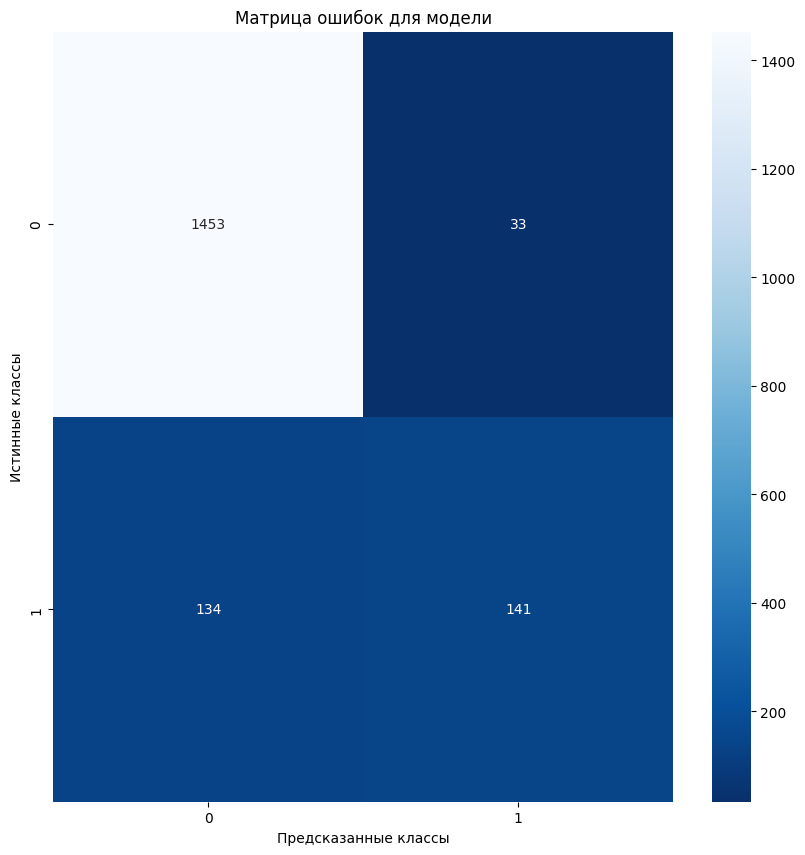

Precision: 0.81
Recall: 0.513


In [ ]:
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.title('Матрица ошибок для модели')
plt.show()

print('Precision:', round(precision_score(y_test, y_pred_class), 3))
print('Recall:', round(recall_score(y_test, y_pred_class), 3))

Матрица ошибок модели:
- True Negative, 1453 - активные клиенты, которых модель правильно предсказала
- False Positive, 33 - число клиентов, которых модель определила, как ушедших, но они являются активными
- False Negative, 134 - число клиентов, которых модель пропустила и определила в качестве активных, но они ушли
- True Positive, 141 - число клиентов, которых модель правильно определила, как ушедших

Модель испытывает промблемы с поиском всех клиентов, которые уходят, но допускает мало ошибок при выборе уходящих клиентов (выбранные в 80% случаев таковыми и являются).

## Выводы

Исходные данные проблем в виде дубликатов и пропусков не имеют, однако разная размерность файлов приводит к тому, что для части клиентов отсутвуют данные в других файлах (до трети в некоторых признаках).

Исследовательский анализ показал, что есть разница в поведении ушедших и действующих клиентов:
- ушедшие клиенты имели более высокий медианный показатель месячных и суммарных трат при том, что суммарыне траты не являются простой комбинацией месячных трат с длительностью договора;
- смещение минимума от минимальных значений на гистограмме распределения общих трат и гистограмма распределения длительности договора указывают на то, что клиенты брали и пробовали различные услуги, после чего принимали решение о прекращении договора
- есть достаточно большой набор признаков, в которых поведение ушедших пользователей отличается от оставшихся

Ушедших клиентов, в большинстве, можно охарактеризовать следующим образом: имеют партнера, не имеют детей, не заинтересованные в ограничениях в интернете, но заинтересованные в антивирусе и высокоскоростном интеренет (оптоволоконном кабеле) и в значительной степени интересующиеся стриминговыми сервисами.

Результаты обучения моделей указывают на то, что между признаками для обучения и и целевым признаком нелинейная связь - чем более гибкая (и сложная) модель используется, тем выше показатель метрики. В качестве модели для тестирования был выбран градиентный бустинг. На тесте модель показала то же значение метрики, что и при обучении, что указвает на корректно выполненное обучение модели. Значение метрики составило 0.9 (согласно требованиям минимально должно было быть не менее 0.85).

Анализ важности признаков указал, что наибольший вклад в предсказания модели вносят те признаки, которые были указаны в исследовательском анализе. Однако для некоторых признаков вклад является сложным и неочевидным для корректной интерпретации (ведет ли увеличение или уменьшение значения признака к определенным изменениям).

Анализ матрицы ошибок указывает на тот факт, что на текущий момент, модель недостаточно хорошо справляется с определением всех клиентов собирающихся разорвать договор, однако имеет высокую точность - почти все клиенты обозначенные, как собирающиеся разорвать договор таковыми и являются.

**Рекомендации**

- для дальнейшего использования модели, подготавливать данные с более равным распределением признаков, заполнение данных не владея всем контекстом может привести к искажению предсказаний модели
- выстраивать стратегию по удержанию клиентов (промокоды и специальные условия) основываясь на признаках указанных в качестве отличительных - оптоволоконный интеренет, стриминговые сервисы, антивирус
- попытаться собрать информацию о возрасте клиентов - судя по портрету ушедшего пользователя он достаточно молод. После чего провести дополнительное исследование о взаимосвязи возраста с остальными признаками